---
lang: es
execute:
  echo: false
  include: false
  fig-align: center
---

# Árboles de regresión

En este capítulo se hará una revisión sobre árboles de regresión y clasificación (CART). Los CART entran dentro de la categoría de análisis supervisado no paramétrico, por lo que tienen una gran flexibilidad.
Otra de las ventajas de estos algoritmos es su interpretabilidad, dado que es muy sencillo entender el efecto de cada variable explicativa en la variable dependiente simplemente siguiendo la estructura del árbol. Además, permiten entender naturalmente las interacciones entre dichas variables.

En la @fig-arbol-decision se muestra un árbol de decisión cuyo objetivo es predecir el índice de progresión de la diabetes utilizando la edad y el índice de masa corporal (BMI). El árbol se interpreta de arriba hacia abajo, lo que indica que el índice de masa corporal es la variable más relevante, ya que aparece en la primera división. Se observa que niveles más altos de BMI están asociados con un aumento en el índice de progresión de la diabetes.

Por otro lado, la edad también influye en la variable dependiente, pero su efecto se observa después de las primeras condiciones basadas en el BMI. Por ejemplo, para pacientes con un BMI menor o igual a 24.35 y una edad menor o igual a 57.5, el índice de progresión de la diabetes es 99.69. Esto destaca (1) la facilidad con la que se pueden interpretar visualmente los árboles de decisión y (2) cómo estos modelos representan de manera natural las interacciones entre diferentes variables.

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(73815)
n = 1000

# Generate all X features at once
X = np.random.uniform(0, 1, (n, 10))
X_cols = [f'X_{i+1}' for i in range(10)]

# Calculate y using vectorized operations where possible
y = (X[:, 0]**2 + np.sin(X[:, 1]) - np.exp(X[:, 2]) + np.log1p(X[:, 3]) + 
     X[:, 4]*X[:, 5] + X[:, 6]*X[:, 7]*X[:, 8] - np.sqrt(X[:, 9]) + 
     X[:, 0]*X[:, 1] - X[:, 2]*X[:, 3] + X[:, 4]*X[:, 5]*X[:, 6] +
     np.random.normal(0, 0.1, n))

# Create DataFrame with all columns
df = pd.DataFrame(X, columns=X_cols)
df['y'] = y

In [35]:
#| label: arbol-decision

from sklearn.model_selection import train_test_split
X = df.drop(columns='y')

y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeRegressor

# Initialize and train the regression tree model
regression_tree = DecisionTreeRegressor(random_state=42, max_depth=3)
regression_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

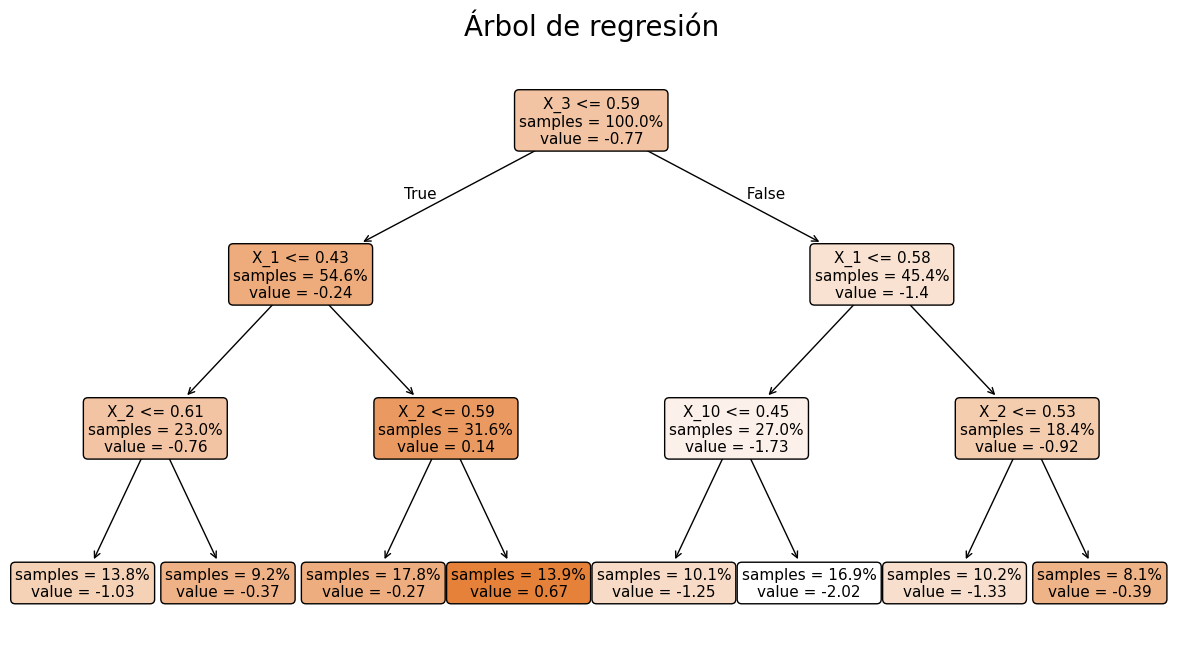

In [36]:
#| label: fig-arbol-decision
#| include: true

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plot_tree(
    regression_tree, 
    feature_names=X_train.columns.tolist(),
    filled=True, 
    rounded=True, 
    impurity=False,
    fontsize=11,
    precision=2,
    proportion=True
)
plt.title("Árbol de regresión", fontsize=20)
plt.show()

Si bien estos modelos no se utilizan demasiado en la práctica y tampoco son el foco de este trabajo, sirven como base para introducir los 
ensambles de árboles que se estudiaran en próximos capítulos y representan el estado de arte.

## Los elementos que componen un árbol

Antes de pasar a la construcción de los árboles, es de interés enfatizar que estos modelos se leen de arriba hacia abajo y definir ciertos elementos que los componen. En primer lugar definimos los nodos como los puntos en los cuales se dividen las observaciones. A su vez pueden clasificarse como:

- Raíz: el primer nodo que contiene todas las observaciones y sobre el cual se hace la primer partición.
- Internos: son los puntos en los cuales se dividieron las observaciones.
- Terminales u hojas: presentan las predicciones finales del modelo, son nodos que no tienen descendientes inmediatos.


Luego, como se ve en la @fig-arbol-decision los nodos definidos anteriormente están unidos por flechas que llamaremos ramas y tienen el objetivo de conectan los distintos nodos del árbol.

Habiendo definido estos elementos podemos pasar a estudiar cómo construir los árboles.

## Construyendo árboles de regresión

Para construir los árboles necesitamos particionar secuencialmente el conjunto de datos $X$ que tenemos. El objetivo final es contruir un modelo re gresión que nos permita estimar el valor de una variable dependiente $Y$. Para ello necesitamos encontrar:

- Encontrar un criterio para particionar los datos.
- Una regla para determinar cuando un nodo es terminal.
- Una forma de asignar un valor a las predicciones de los nodos terminales.

### Criterio para particionar los datos

Dado que necesitamos crear $R_1,R_2,...,R_J$ regiones distintas y disjuntas que, a priori, podrían tener cualquier forma. Sin embargo, por simplicidad tendrán forma rectangular. Además, dado que se trata de un algoritmo de regresión supervisado tiene el objetivo de predecir con el menor error posible, por lo que se suele utilizar el error cuadrático medio para medir el error:
$$
MSE=\frac{1}{n}\sum_{n=1}^{N}(Y-\hat{Y})^2
$$

con $n$ la cantidad de observaciones, $Y$ los valores reales de la variable dependiente y $\hat{Y}$ las predicciones realizadas por nuestro modelo con la muestra $X$.

En definitiva, si lo que buscamos son regiones que minimicen el error cuadrático medio podemos expresarlo como
$$
MSE(T)=\frac{1}{n}\sum_{j=1}^{J}\sum_{i:\in R_J}(Y(i)-\hat{Y}_{R_j})^2
$$

con el árbol $T$, n el número total de observaciones en la muestra, $J$ el número de regiones $R$, $Y(i)$ el valor real de las observaciones $i$ que cayeron se encuentran en la región $R_j$ y $\hat{Y}_{R_j}$ la predicción de nuestro modelo. 

Sin embargo, calcular esta expresión es computacionalmente imposible dado que implica buscar todas las posibles particiones en todas las posibles regiones que se pueden generar con la muestra. A modo de ejemplo esto significa que si tenemos $p$ variables y cada variable tiene $s$ puntos en los que podría ser particionada, el número total de posibles particionas de todas las variables en cada nodo sería $m * p$. Dado que cada partición es binaria, el número de nodos crece exponencialmente con la profundidad del árbol $d$. Es decir que para calcular la cantidad total de particiones posibles ($TP$) para todo el árbol tendríamos que calcular 

$$
TP=\sum_{d=0}^{D}m * p*{2^{d}}
$$

que crece exponencialmente por lo que se hace computacionalmente muy intensiva.

Es por ello que se utiliza el algoritmo conocido como división binaria recursiva, este algoritmo, que va de arriba hacia abajo en el árbol, se considera greedy dado en cada paso solo mira el valor óptimo en ese momento, por lo que hace menos cálculos aunque puede que no llegue a la solución óptima.
En definitiva el algoritmo consiste en considerar todas las $X_1,X_2,...,X_p$ y todos los posibles valores en los cuales se podría particionar ($s$) para quedarnos con el que minimice el error cuadrático medio en ese paso. En definitiva buscamos

$$
MSE(T)=\frac{1}{n}\sum_{r=1}^{R}\sum_{i:x_i\in R_r(j,s)}(Y(i)-\hat{Y}_{R_r})^2
$$

con n el número de observaciones, $R$ el número total de regiones después de aplicar todas las divisiones, $R_r(j,s)$La región $r$ creada al dividir el predictor $X_j$ en el punto de corte $s$, siendo $X_j$ el predictor que minimiza el error, $Y(i)$ el valor real de las observaciones $i$ dentro de la región $R_r$ y $\hat{Y}_{R_r}$ los valores predichos para todas las observaciones $i$ en la región $R_r$

Este algoritmo ya no crece de manera exponencial como el anterior, por lo que es más sencillo de calcular que el anterior.


### Definir cuando un nodo es terminal

Definir cuando un nodo es terminal es equivalente a pensar cuando un nodo

### Asignar valores a nodos terminales

Dado que la función a optimizar es el error cuadrático medio, se puede probar que la media muestral será la constante que minimice ese error.

Partimos de que queremos c que minimice
$$
		MSE(c)=\frac{1}{n}\sum_{i=1}^{n}(y_i-c)^2 
$$
	
para ello primero derivamos con respecto de c
$$
\begin{aligned}
	\frac{d}{dc}MSE(c)&=\frac{1}{n}\sum_{i=1}^{n}(y_i-c)^2  \\
	\frac{d}{dc}MSE(c)&=\frac{1}{n}\sum_{i=1}^{n}-2(y_i-c)  \\
	\frac{d}{dc}MSE(c)&=-\frac{2}{n}\sum_{i=1}^{n}(y_i-c)
\end{aligned}
$$

y luego igualamos a cero:
$$
\begin{aligned}
	-\frac{2}{n}\sum_{i=1}^{n}(y_i-c)&=0  \\
	\sum_{i=1}^{n}(y_i-c)&=0  \\
	\sum_{i=1}^{n}y_i-nc&=0  \\
	\sum_{i=1}^{n}y_i&=nc  \\
	\frac{1}{n}\sum_{i=1}^{n}y_i&=c  \\
\end{aligned}
$$

Por lo que los valores que tendrán los nodos terminales (predicciones) serán simplemente la media de las observaciones que están en ese nodo.


## Poda de árboles

Construir un árbol con demasiadas particiones puede llevar a un sobre ajuste. Básicamente porque si pensamos en el árbol más grande que se puede construir con una muestra, el mismo tendría un nodo terminal por cada observación, lo cual llevaría a un error muy bajo en la muestra de entrenamiento, pero una capacidad de generalización muy mala.

Para evitar esto, buscaremos poner un límite a cuanto puede crecer el árbol, para ello existen múltiples alternativas como fijar cotas a la profundidad del árbol, al número de observaciones que pueden quedar en la misma hoja o bien hacer crecer un árbol muy grande y luego "podarlo" para obtener árboles más pequeños que podemos comparar con validación cruzada. Este último procedimiento será descrito en el trabajo.

Antes de describir el procedimiento es importante definir $T_0$ como un árbol maximal y $T'$ sería un subárbol podado de T. Para que un árbol sea considerado sub-árbol de otro tiene que tener $T' = T_0 - T_t$, donde $T_t$ es una rama (subárbol) que se elimina de $T_0$ para obtener $T'$.

El problema de querer encontrar sub-árboles es que pueden ser demasiados, haciendo que sea computacionalmente demasiado exigente. Es por ello que se utiliza cost complexity pruning para trabajar un pequeño número de subárboles. A continuación vemos la ecuación:

$$
\sum_{m=1}^{|T|}\sum_{i:x_i\in R_r(j,s)}(Y(i)-\hat{Y}_{R_r})^2+ \alpha |T|
$$

con $\alpha$ que sirve para regular la intensidad de la regularización y $|T|$ el número de nodos terminales del árbol T. Esta expresión permite obtener una secuencia ordenada de subárboles que podemos evaluar por medio de validación cruzada. Queda claro que aumentar $\alpha$ se generan árboles más pequeños.

Se puede ver en la @fig-arbol-alpha como a medida que aumentan los valores de $\alpha$ inicialmente el error cuadrático medio disminuye, pero luego empieza a subir debido al sobre ajuste.


In [37]:
#| label: calc-arbol-alpha

from sklearn.metrics import mean_squared_error

# Definir un rango de complejidades del árbol (número máximo de nodos hoja)
max_leaf_nodes_list = [i for i in range(2,250, 10)]

# Entrenar y evaluar modelos
test_mse_scores = []
for max_leaf_nodes in max_leaf_nodes_list:
    reg = DecisionTreeRegressor(random_state=42, max_leaf_nodes=max_leaf_nodes)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_mse_scores.append(mse)

# Convertir los resultados a un DataFrame para análisis
results_df = pd.DataFrame({
    'max_leaf_nodes': max_leaf_nodes_list,
    'Error Cuadrático Medio': test_mse_scores
})

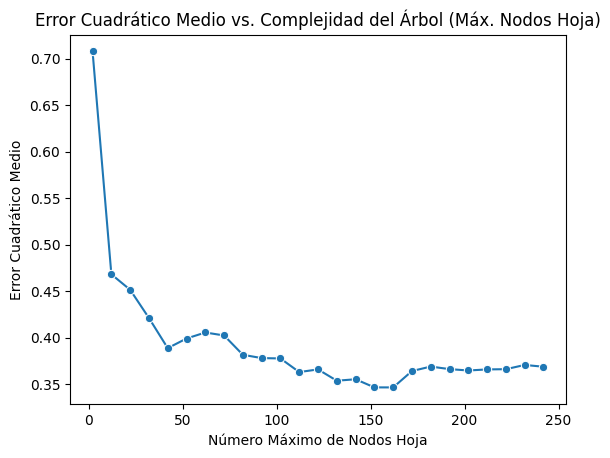

In [38]:
#| label: fig-arbol-alpha
#| include: true

import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=max_leaf_nodes_list, y=test_mse_scores, marker='o')
plt.xlabel('Número Máximo de Nodos Hoja')
plt.ylabel('Error Cuadrático Medio')
plt.title('Error Cuadrático Medio vs. Complejidad del Árbol (Máx. Nodos Hoja)')
plt.show()


## Outliers y Limitaciones

### Outliers

Es sabido que las regresiones lineales son muy sensibles a \textit{outliers}. Sin embargo, como se ve en Brieman los valores atipicos terminan siendo aislados en pequeños nodos. Esta capacidad de aislar los \textit{outliers} permite hacer el modelo menos sensible a datos atípicos.

### Limitaciones

Dado que este trabajo se centra en la interpretación de modelos, la principal limitación que se destaca es la falta de estabilidad. Es decir que la varianza de los árboles genera que las particiones puedan ser muy distintas ante cambios en los datos. Esto lógicamente atenta contra la interpretación.

Otras limitaciones son la falta de suavidad y las dificultades que tienen para captar una estructura aditiva en los datos.